# This notebook computes the maps and cross correlations between LIM and gals


In [1]:
import sys
sys.path.append('/home/jlbernal/preLIMinary/')
sys.path.append('/home/jlbernal/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import pickle
import healpy as hp
from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


LC_path='/home/jlbernal/LightCone_S82_UM/'

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5



In [2]:
from nbodykit.source.mesh.catalog import CompensateCICShotnoise,get_compensation
from nbodykit.algorithms import FFTPower
from nbodykit.source.mesh.array import ArrayMesh
import pmesh

kmin=0*u.Mpc**-1
kmax=2*u.Mpc**-1
dk=0.02*u.Mpc**-1

compensation = get_compensation(interlaced=False,resampler='cic')


In [3]:
def save_pickle(name,obj):
    '''
    name without extension
    '''
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_pickle(name):
    '''
    name without extensions
    '''
    with open(name+'.pickle', 'rb') as handle:
        obj = pickle.load(handle)
    return obj

## low-z maps

In [4]:
def lowz_LC_params(line,ngal):
    h=0.678
    zmin = 0.4;zmax = 1.4
    zmid=(zmax+zmin)/2
    ang_lim=20*u.deg
    R = 700
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=2,
                      spectral_supersample=4,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=30,
                      dk=0.02*u.Mpc**-1,
                      seed=1234)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.1, 
                    RAObs_width=ang_lim, DECObs_width=ang_lim,
                    RA_width=ang_lim, DEC_width=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':1.5e10*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    elif line=='lrg':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6e11*u.Msun/h, 
                                                                 'alpha':0.53,'sigma_MHI':0.2})),
                                 do_intensity=False,
                                gal_type='lrg',ngal=ngal,number_count=True,
                                do_angular_smooth=False, do_spectral_smooth=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [5]:
LC_HI=make_measurements(lowz_LC_params('HI',5e-4/0.678**-3*u.Mpc**-3))

In [6]:
HI_map=LC_HI.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.664944851238623
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:880: UserWarning: % of emitters of HI line left out filtering = 0.7149562944050092
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [7]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_HIlowz_T', m = HI_map)

In [6]:
LC_lrg=make_measurements(lowz_LC_params('lrg',5e-4/0.678**-3*u.Mpc**-3))
LC_lrg.update(do_angular_smooth=False, do_spectral_smooth=False)

In [7]:
lrg_map=LC_lrg.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.664944851238623
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:453: RuntimeWarning: divide by zero encountered in log10
  inds_gal = np.where((np.log10(self.halo_catalog_all['SM_HALO'])>8)&(self.halo_catalog_all['SFR_HALO']>0))
/home/jlbernal/preLIMinary/source/survey.py:460: RuntimeWarning: invalid value encountered in true_divide
  sSFR = self.halo_catalog_all['SFR_HALO']/self.halo_catalog_all['SM_HALO']
/home/jlbernal/preLIMinary/source/survey.py:883: UserWarning: % of emitters of HI line left out filtering = 0.6529507476152654
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [11]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_lrglowz_n', m = lrg_map)

In [12]:
LC_lrg_highn=make_measurements(lowz_LC_params('lrg',20*5e-4/0.678**-3*u.Mpc**-3))
LC_lrg_highn.update(do_angular_smooth=False, do_spectral_smooth=False)

In [13]:
lrg_map_highn=LC_lrg_highn.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.664944851238623
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:453: RuntimeWarning: divide by zero encountered in log10
  inds_gal = np.where((np.log10(self.halo_catalog_all['SM_HALO'])>8)&(self.halo_catalog_all['SFR_HALO']>0))
/home/jlbernal/preLIMinary/source/survey.py:460: RuntimeWarning: invalid value encountered in true_divide
  sSFR = self.halo_catalog_all['SFR_HALO']/self.halo_catalog_all['SM_HALO']
/home/jlbernal/preLIMinary/source/survey.py:883: UserWarning: % of emitters of HI line left out filtering = 0.678962598246835
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [14]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_lrglowz_n_highn', m = lrg_map_highn)

## high-z maps

In [6]:
def highz_LC_params(line,ngal):
    h=0.678
    zmin = 2.2;zmax = 3.2
    zmid=(zmax+zmin)/2
    ang_lim=20*u.deg
    R = 700
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=2,
                      spectral_supersample=4,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=30,
                      dk=0.02*u.Mpc**-1,
                      seed=1234)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.1, 
                    RAObs_width=ang_lim, DECObs_width=ang_lim,
                    RA_width=ang_lim, DEC_width=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    elif line=='lrg':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False,
                                gal_type='lrg',ngal=ngal,number_count=True,
                                do_angular_smooth=False, do_spectral_smooth=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    elif line=='elg':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True,
                                gal_type='elg',ngal=ngal,number_count=True,
                                do_angular_smooth=False, do_spectral_smooth=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [7]:
LC_Lya=make_measurements(highz_LC_params('Lyalpha',1e-4**-3*u.Mpc**-3))

In [16]:
Lya_map=LC_Lya.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.22159539469130418
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:880: UserWarning: % of emitters of Lyalpha line left out filtering = 0.2507373331210422
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [17]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_Lyahighz_T', m = Lya_map)

In [76]:
LC_elg=make_measurements(highz_LC_params('elg',1e-4*u.Mpc**-3))
LC_elg.update(do_angular_smooth=False, do_spectral_smooth=False)

In [77]:
elg_map=LC_elg.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.22159539469130418
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:440: UserWarning: Filling the corners requires a buffering z_max = 3.249, but input z_max = 3.230. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
/home/jlbernal/preLIMinary/source/survey.py:453: RuntimeWarning: divide by zero encountered in log10
  inds_gal = np.where((np.log10(self.halo_catalog_all['SM_HALO'])>8)&(self.halo_catalog_all['SFR_HALO']>0))
/home/jlbernal/preLIMinary/source/survey.py:460: RuntimeWarning: invalid value encountered in true_divide
  sSFR = self.halo_catalog_all['SFR_HALO']/self.halo_catalog_all['SM_HALO']
/home/jlbernal/preLIMinary/sour

In [79]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_elghighz_n', m = elg_map)

In [80]:
LC_elg_highn=make_measurements(highz_LC_params('elg',20*1e-4*u.Mpc**-3))
LC_elg_highn.update(do_angular_smooth=False, do_spectral_smooth=False)

In [81]:
elg_map_highn=LC_elg_highn.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.22159539469130418
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:440: UserWarning: Filling the corners requires a buffering z_max = 3.249, but input z_max = 3.230. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
/home/jlbernal/preLIMinary/source/survey.py:453: RuntimeWarning: divide by zero encountered in log10
  inds_gal = np.where((np.log10(self.halo_catalog_all['SM_HALO'])>8)&(self.halo_catalog_all['SFR_HALO']>0))
/home/jlbernal/preLIMinary/source/survey.py:460: RuntimeWarning: invalid value encountered in true_divide
  sSFR = self.halo_catalog_all['SFR_HALO']/self.halo_catalog_all['SM_HALO']
/home/jlbernal/preLIMinary/sour

In [82]:
np.savez('/home/jlbernal/lim_LC_prods/map_supersample_elghighz_n_highn', m = elg_map_highn)

## Make cross correlations

#### prepare compensations

In [8]:
HI_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_HIlowz_T.npz')['m']
lrg_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_lrglowz_n.npz')['m']
lrg_highn_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_lrglowz_n_highn.npz')['m']
Lya_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_Lyahighz_T.npz')['m']
elg_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_elghighz_n.npz')['m']
elg_highn_map = np.load('/home/jlbernal/lim_LC_prods/map_supersample_elghighz_n_highn.npz')['m']


In [9]:
def make_map(m,Nmesh,Lbox):
    pm = pmesh.pm.ParticleMesh(Nmesh, BoxSize=Lbox, dtype='float32', resampler='cic')
    #Make realfield object
    field = pm.create(type='real')
    field[...] = m
    return field

In [10]:
HI_map_touse = make_map(HI_map,HI_map.shape,LC_HI.Lbox.value)
lrg_map_touse = make_map(lrg_map,lrg_map.shape,LC_HI.Lbox.value)
lrg_highn_map_touse = make_map(lrg_highn_map,lrg_highn_map.shape,LC_HI.Lbox.value)

/home/jlbernal/preLIMinary/source/survey.py:335: UserWarning: % of survey volume lost due to inner cube = 0.664944851238623
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


In [11]:
Lya_map_touse = make_map(Lya_map,Lya_map.shape,LC_Lya.Lbox.value)
elg_map_touse = make_map(elg_map,elg_map.shape,LC_Lya.Lbox.value)
elg_highn_map_touse = make_map(elg_highn_map,elg_highn_map.shape,LC_Lya.Lbox.value)

/home/jlbernal/preLIMinary/source/survey.py:335: UserWarning: % of survey volume lost due to inner cube = 0.22159539469130418
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


In [12]:
compensation = get_compensation(interlaced=False,resampler='cic')

HI_map_touse = (HI_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
lrg_map_touse = (lrg_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
lrg_highn_map_touse = (lrg_highn_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
Lya_map_touse = (Lya_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
elg_map_touse = (elg_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
elg_highn_map_touse = (elg_highn_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()


In [13]:
elg_map_touse = (elg_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()
elg_highn_map_touse = (elg_highn_map_touse.r2c().apply(compensation[0][1], kind=compensation[0][2])).c2r()


In [14]:
#low z
HIxlrg=FFTPower(HI_map_touse, '2d', second=lrg_map_touse, Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_HI.Mpch**-1).value, kmin=kmin.to(LC_HI.Mpch**-1).value, 
                kmax=kmax.to(LC_HI.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))

HIxlrg_highn=FFTPower(HI_map_touse, '2d', second=lrg_highn_map_touse, Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_HI.Mpch**-1).value, kmin=kmin.to(LC_HI.Mpch**-1).value, 
                kmax=kmax.to(LC_HI.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))


In [15]:
HIxHI = FFTPower(HI_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_HI.Mpch**-1).value, kmin=kmin.to(LC_HI.Mpch**-1).value, 
                kmax=kmax.to(LC_HI.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))

lrgxlrg = FFTPower(lrg_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_HI.Mpch**-1).value, kmin=kmin.to(LC_HI.Mpch**-1).value, 
                kmax=kmax.to(LC_HI.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))

lrg_highnxlrg_highn = FFTPower(lrg_highn_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_HI.Mpch**-1).value, kmin=kmin.to(LC_HI.Mpch**-1).value, 
                kmax=kmax.to(LC_HI.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))


In [16]:
#highz
Lyaxelg=FFTPower(Lya_map_touse, '2d', second=elg_map_touse, Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))

Lyaxelg_highn=FFTPower(Lya_map_touse, '2d', second=elg_highn_map_touse, Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))


In [17]:
LyaxLya=FFTPower(Lya_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))

elgxelg=FFTPower(elg_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))

elg_highnxelg_highn=FFTPower(elg_highn_map_touse, '2d', Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))



In [18]:
kHIxlrg, PkHIxlrg = (HIxlrg.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(HIxlrg.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_HI.unit
kHIxlrg_highn, PkHIxlrg_highn = (HIxlrg_highn.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(HIxlrg_highn.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_HI.unit

kLyaxelg, PkLyaxelg = (Lyaxelg.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(Lyaxelg.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_Lya.unit
kLyaxelg_highn, PkLyaxelg_highn = (Lyaxelg_highn.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(Lyaxelg_highn.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_Lya.unit

kHIxHI, PkHIxHI = (HIxHI.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(HIxHI.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_HI.unit
klrgxlrg, Pklrgxlrg = (lrgxlrg.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(lrgxlrg.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_HI.unit
klrg_highnxlrg_highn, Pklrg_highnxlrg_highn = (lrg_highnxlrg_highn.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(lrg_highnxlrg_highn.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_HI.unit

kLyaxLya, PkLyaxLya = (LyaxLya.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(LyaxLya.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_Lya.unit
kelgxelg, Pkelgxelg = (elgxelg.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(elgxelg.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_Lya.unit
kelg_highnxelg_highn, Pkelg_highnxelg_highn = (elg_highnxelg_highn.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(elg_highnxelg_highn.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_Lya.unit



In [19]:
cmap_CO = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#32465c', '#afb9bd'])
colors=cmap_CO(np.linspace(0,1,3))

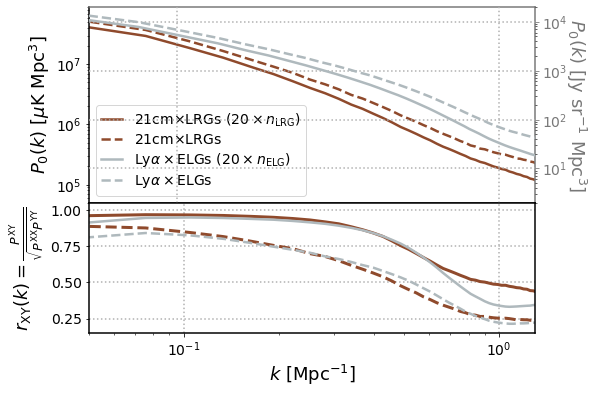

In [31]:
from matplotlib.lines import Line2D
plt.rcParams['font.size'] = 14

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.,height_ratios=[3,2])

ax=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0, 0], frame_on=False)

ax.loglog(kHIxlrg, PkHIxlrg, '--', color=dark_red)
ax.loglog(kHIxlrg_highn, PkHIxlrg_highn, color=dark_red)
ax.set_ylabel("$P_0 (k)$ [$\mu$K Mpc$^3$]",fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.set_xlim(0.05, 1.3)
ax.set_ylim(5e4,9e7)

#ax1.xaxis.tick_top()
ax1.yaxis.tick_right()

ax1.loglog(kLyaxelg, PkLyaxelg, '--', color=light_blue)
ax1.loglog(kLyaxelg_highn, PkLyaxelg_highn, color=light_blue)
ax1.set_ylabel("$P_0 (k)$ [Jy sr$^{-1}$ Mpc$^3$]",fontsize=18, color=grey,rotation=270, labelpad=20)
ax1.grid(linestyle='dotted', linewidth=1.5)
ax1.set_xlim(0.053, 1.3)
ax1.set_ylim(2e0,2e4)

ax1.yaxis.label.set_color(grey)
ax1.yaxis.set_label_position('right') 
ax1.tick_params(axis='y', colors=grey)
#ax01.axes.get_xaxis().set_ticks([])
ax.grid(linestyle='dotted', linewidth=1.5)

ax1.spines['top'].set_edgecolor(grey)
ax.spines['right'].set_edgecolor(grey)
ax.spines['top'].set_edgecolor(grey)



custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], linestyle='--',color= dark_red, lw=2.5),
                Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], linestyle='--',color= light_blue, lw=2.5)]
ax.legend(custom_lines, [r'21cm$\times$LRGs ($20\times n_{\rm LRG}$)',r'21cm$\times$LRGs',
                         r'Ly$\alpha\times$ELGs ($20\times n_{\rm ELG}$)',r'Ly$\alpha\times$ELGs'], 
            ncol=1, fontsize=14, labelspacing=0.3, columnspacing=0.2, handlelength=1.5, loc='lower left')


ax=fig.add_subplot(gs[1,0])
ax.plot(kHIxlrg, PkHIxlrg/np.sqrt(PkHIxHI*Pklrgxlrg), '--',color=dark_red,lw=3)
ax.plot(kHIxlrg_highn, PkHIxlrg_highn/np.sqrt(PkHIxHI*Pklrg_highnxlrg_highn), dark_red,lw=3)
ax.plot(kLyaxelg, PkLyaxelg/np.sqrt(PkLyaxLya*Pkelgxelg), '--',color=light_blue)
ax.plot(kLyaxelg_highn, PkLyaxelg_highn/np.sqrt(PkLyaxLya*Pkelg_highnxelg_highn), light_blue)
ax.set_xlim(0.05, 1.3)
ax.set_ylim(0.15,1.05)
ax.set_ylabel(r'$r_{\rm XY}(k) = \frac{P^{\rm XY}}{\sqrt{P^{\rm XX}P^{\rm YY}}}$',fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.semilogx()
ax.set_xlabel(r"$k$ [Mpc$^{-1}]$",fontsize=18)

plt.savefig('../../lim_LC_prods/Pkgal_cross_all.pdf', bbox_inches='tight', dpi=300)


# separated maps-

In [ ]:
ax00=fig.add_subplot(gs[:, 0])
ax01=fig.add_subplot(gs[:, 0], frame_on=False)

ax00.loglog(TiCO, BiCO_noise, color=dark_blue)
ax00.loglog(TiCO, BiCO_nonoise, '--', color=dark_blue)
ax00.loglog(TiHI, BiHI_noise, color=dark_red)
ax00.loglog(TiHI, BiHI_nonoise, '--', color=dark_red)
ax00.set_xlabel(r"$\Delta T$ [$\mu K$]", fontsize = 15)
ax00.set_ylabel("$B_{i}(\Delta T)$", fontsize=15)
ax00.set_ylim(1e3,5e6)

ax01.xaxis.tick_top()
ax01.yaxis.tick_right()
ax01.loglog(TiLya, BiLya_noise, color=light_blue)
ax01.loglog(TiLya, BiLya_nonoise, '--', color=light_blue)
ax01.loglog(TiCII, BiCII_noise, color=light_red)
ax01.loglog(TiCII, BiCII_nonoise, '--', color=light_red)
ax01.set_xlabel("$\Delta I$ [Jy sr$^{-1}$]", fontsize = 15)
ax01.set_ylabel("$B_{i}(\Delta I)$",color=grey, fontsize=15, rotation=270, labelpad=18)
ax01.set_ylim(1e3,5e6)

ax01.yaxis.label.set_color(grey)
ax01.yaxis.set_label_position('right') 
ax01.tick_params(axis='y', colors=grey)
#ax01.axes.get_xaxis().set_ticks([])

ax01.xaxis.label.set_color(grey)
ax01.xaxis.set_label_position('top') 
ax01.tick_params(axis='x', colors=grey)

ax01.spines['top'].set_edgecolor(grey)
ax00.spines['right'].set_edgecolor(grey)
ax00.spines['top'].set_edgecolor(grey)

ax00.grid(linestyle='dotted', linewidth=1.5)

custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], color=dark_blue, lw=2.5),
                Line2D([0], [0], color=light_red, lw=2.5),
                Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], color= 'black', lw=2.5),
                Line2D([0], [0], linestyle='--',color= 'black', lw=2.5)]
ax01.legend(custom_lines, ['21cm', 'CO', 'CII',r'Ly$\alpha$', 'w/ noise', 'w/o noise'], 
            ncol=3, fontsize=12, labelspacing=0.3, columnspacing=0.3, handlelength=1.5, loc='lower left')




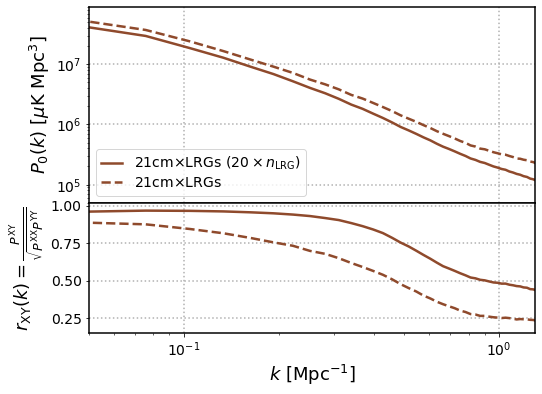

In [99]:
from matplotlib.lines import Line2D
plt.rcParams['font.size'] = 14

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.,height_ratios=[3,2])

ax=fig.add_subplot(gs[0,0])
ax.loglog(kHIxlrg, PkHIxlrg, '--', color=dark_red)
ax.loglog(kHIxlrg_highn, PkHIxlrg_highn, color=dark_red)
ax.set_ylabel("$P_0 (k)$ [$\mu$K Mpc$^3$]",fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.set_xlim(0.05, 1.3)
ax.set_ylim(5e4,9e7)

custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], linestyle='--',color= dark_red, lw=2.5)]
ax.legend(custom_lines, [r'21cm$\times$LRGs ($20\times n_{\rm LRG}$)',r'21cm$\times$LRGs'], 
            ncol=1, fontsize=14, labelspacing=0.3, columnspacing=0.2, handlelength=1.5, loc='lower left')


ax=fig.add_subplot(gs[1,0])
ax.plot(kHIxlrg, PkHIxlrg/np.sqrt(PkHIxHI*Pklrgxlrg), '--',color=dark_red)
ax.plot(kHIxlrg_highn, PkHIxlrg_highn/np.sqrt(PkHIxHI*Pklrg_highnxlrg_highn), dark_red)
ax.set_xlim(0.05, 1.3)
ax.set_ylim(0.15,1.02)
ax.set_ylabel(r'$r_{\rm XY}(k) = \frac{P^{\rm XY}}{\sqrt{P^{\rm XX}P^{\rm YY}}}$',fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.semilogx()
ax.set_xlabel(r"$k$ [Mpc$^{-1}]$",fontsize=18)

plt.savefig('../../lim_LC_prods/Pkgal_cross_lowz.pdf', bbox_inches='tight', dpi=300)


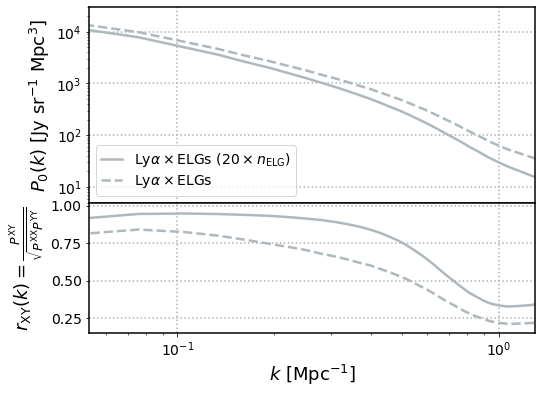

In [103]:
from matplotlib.lines import Line2D
plt.rcParams['font.size'] = 14

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.,height_ratios=[3,2])

ax=fig.add_subplot(gs[0,0])
ax.loglog(kLyaxelg, PkLyaxelg, '--', color=light_blue)
ax.loglog(kLyaxelg_highn, PkLyaxelg_highn, color=light_blue)
ax.set_ylabel("$P_0 (k)$ [Jy sr$^{-1}$ Mpc$^3$]",fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.set_xlim(0.053, 1.3)
ax.set_ylim(5,3e4)

custom_lines = [Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], linestyle='--',color= light_blue, lw=2.5)]
ax.legend(custom_lines, [r'Ly$\alpha\times$ELGs ($20\times n_{\rm ELG}$)',r'Ly$\alpha\times$ELGs'], 
            ncol=1, fontsize=14, labelspacing=0.3, columnspacing=0.2, handlelength=1.5, loc='lower left')


ax=fig.add_subplot(gs[1,0])
ax.plot(kLyaxelg, PkLyaxelg/np.sqrt(PkLyaxLya*Pkelgxelg), '--',color=light_blue)
ax.plot(kLyaxelg_highn, PkLyaxelg_highn/np.sqrt(PkLyaxLya*Pkelg_highnxelg_highn), light_blue)
ax.set_xlim(0.053, 1.3)
ax.set_ylim(0.15,1.02)
ax.set_ylabel(r'$r_{\rm XY}(k) = \frac{P^{\rm XY}}{\sqrt{P^{\rm XX}P^{\rm YY}}}$',fontsize=18)
ax.grid(linestyle='dotted', linewidth=1.5)
ax.semilogx()
ax.set_xlabel(r"$k$ [Mpc$^{-1}]$",fontsize=18)

plt.savefig('../../lim_LC_prods/Pkgal_cross_Lyaghz.pdf', bbox_inches='tight', dpi=300)


In [16]:
(1e3*LC_HI.Mpch**3)

<Quantity 3208.5655661 Mpc3>